In [1]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import os

from PIL import Image
from torchvision.transforms import Resize, Compose, ToTensor, Normalize
import numpy as np
import skimage
import matplotlib.pyplot as plt

import time

def get_mgrid(sidelen, dim=2):
    '''Generates a flattened grid of (x,y,...) coordinates in a range of -1 to 1.
    sidelen: int
    dim: int'''
    tensors = tuple(dim * [torch.linspace(-1, 1, steps=sidelen)])
    mgrid = torch.stack(torch.meshgrid(*tensors), dim=-1)
    mgrid = mgrid.reshape(-1, dim)
    return mgrid

# os.environ["CUDA_VISIBLE_DEVICES"] = "0"

/workspace/miniconda3/envs/torch/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Now, we code up the sine layer, which will be the basic building block of SIREN. This is a much more concise implementation than the one in the main code, as here, we aren't concerned with the baseline comparisons.

In [2]:
class SineLayer(nn.Module):

    def __init__(self, in_features, out_features, bias=True,
                 is_first=False, omega_0=30):
        super().__init__()
        self.omega_0 = omega_0
        self.is_first = is_first

        self.in_features = in_features
        self.linear = nn.Linear(in_features, out_features, bias=bias)

        self.init_weights()

    def init_weights(self):
        with torch.no_grad():
            if self.is_first:
                self.linear.weight.uniform_(-1 / self.in_features,
                                             1 / self.in_features)
            else:
                self.linear.weight.uniform_(-np.sqrt(6 / self.in_features) / self.omega_0,
                                             np.sqrt(6 / self.in_features) / self.omega_0)

    def forward(self, input):
        return torch.sin(self.omega_0 * self.linear(input))

    def forward_with_intermediate(self, input):
        # For visualization of activation distributions
        intermediate = self.omega_0 * self.linear(input)
        return torch.sin(intermediate), intermediate


class Siren(nn.Module):
    def __init__(self, in_features, hidden_features, hidden_layers, out_features, outermost_linear=False,
                 first_omega_0=30, hidden_omega_0=30.):
        super().__init__()

        self.net = []
        self.net.append(SineLayer(in_features, hidden_features,
                                  is_first=True, omega_0=first_omega_0))

        for i in range(hidden_layers):
            self.net.append(SineLayer(hidden_features, hidden_features,
                                      is_first=False, omega_0=hidden_omega_0))

        if outermost_linear:
            final_linear = nn.Linear(hidden_features, out_features)

            with torch.no_grad():
                final_linear.weight.uniform_(-np.sqrt(6 / hidden_features) / hidden_omega_0,
                                              np.sqrt(6 / hidden_features) / hidden_omega_0)

            self.net.append(final_linear)
        else:
            self.net.append(SineLayer(hidden_features, out_features,
                                      is_first=False, omega_0=hidden_omega_0))

        self.net = nn.Sequential(*self.net)

    def forward(self, coords):
        coords = coords.clone().detach().requires_grad_(True) # allows to take derivative w.r.t. input
        output = self.net(coords)
        return output, coords

    def forward_with_activations(self, coords, retain_grad=False):
        '''Returns not only model output, but also intermediate activations.
        Only used for visualizing activations later!'''
        activations = OrderedDict()

        activation_count = 0
        x = coords.clone().detach().requires_grad_(True)
        activations['input'] = x
        for i, layer in enumerate(self.net):
            if isinstance(layer, SineLayer):
                x, intermed = layer.forward_with_intermediate(x)

                if retain_grad:
                    x.retain_grad()
                    intermed.retain_grad()

                activations['_'.join((str(layer.__class__), "%d" % activation_count))] = intermed
                activation_count += 1
            else:
                x = layer(x)

                if retain_grad:
                    x.retain_grad()

            activations['_'.join((str(layer.__class__), "%d" % activation_count))] = x
            activation_count += 1

        return activations

And finally, differential operators that allow us to leverage autograd to compute gradients, the laplacian, etc.

In [3]:
def laplace(y, x):
    grad = gradient(y, x)
    return divergence(grad, x)


def divergence(y, x):
    div = 0.
    for i in range(y.shape[-1]):
        div += torch.autograd.grad(y[..., i], x, torch.ones_like(y[..., i]), create_graph=True)[0][..., i:i+1]
    return div


def gradient(y, x, grad_outputs=None):
    if grad_outputs is None:
        grad_outputs = torch.ones_like(y)
    grad = torch.autograd.grad(y, [x], grad_outputs=grad_outputs, create_graph=True)[0]
    return grad

# Experiments

For the image fitting and poisson experiments, we'll use the classic cameraman image.

In [4]:
import scipy.io.wavfile as wavfile
import io
from IPython.display import Audio

if not os.path.exists('./data/gt_bach.wav'):
    !wget https://vsitzmann.github.io/siren/img/audio/gt_bach.wav

In [5]:
class AudioFile(torch.utils.data.Dataset):
    def __init__(self, filename):
        self.rate, self.data = wavfile.read(filename)
        self.data = self.data.astype(np.float32)
        self.timepoints = get_mgrid(len(self.data), 1)

    def get_num_samples(self):
        return self.timepoints.shape[0]

    def __len__(self):
        return 1

    def __getitem__(self, idx):
        amplitude = self.data
        scale = np.max(np.abs(amplitude))
        amplitude = (amplitude / scale)
        amplitude = torch.Tensor(amplitude).view(-1, 1)
        return self.timepoints, amplitude

In [6]:
bach_audio = AudioFile('./data/gt_bach.wav')

dataloader = DataLoader(bach_audio, shuffle=True, batch_size=1, pin_memory=True, num_workers=0)



/workspace/miniconda3/envs/torch/lib/python3.8/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1699449229234/work/aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [7]:
##################  GT Results ##################  
rate, _ = wavfile.read('./data/gt_bach.wav')
model_input, ground_truth = next(iter(dataloader))
Audio(ground_truth.squeeze().numpy(),rate=rate)
print(rate)

44100


# Baseline Results for Bach Audio

Step 0, Total loss 0.024715


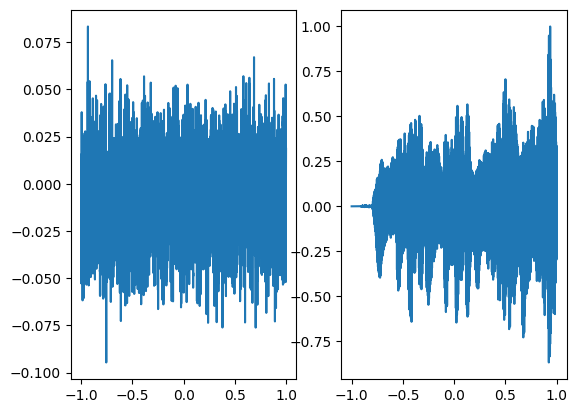

Step 150, Total loss 0.001555


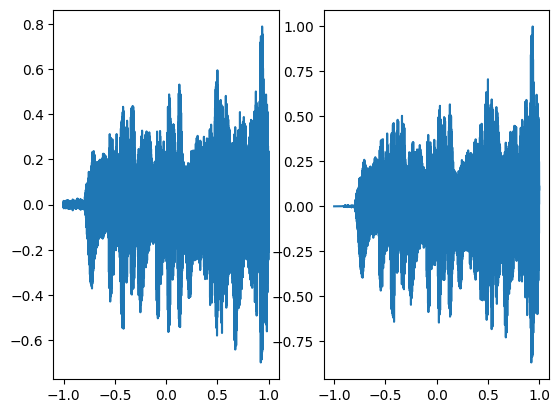

Step 300, Total loss 0.001428


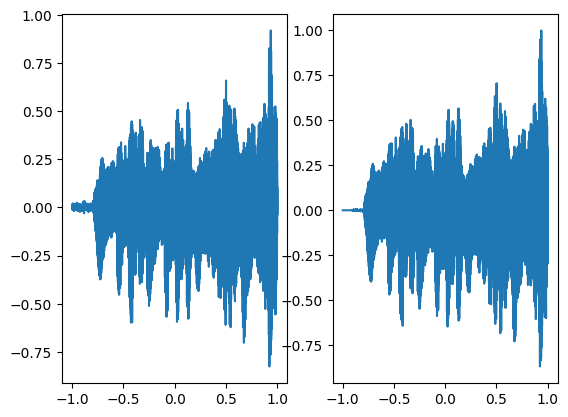

Step 450, Total loss 0.000691


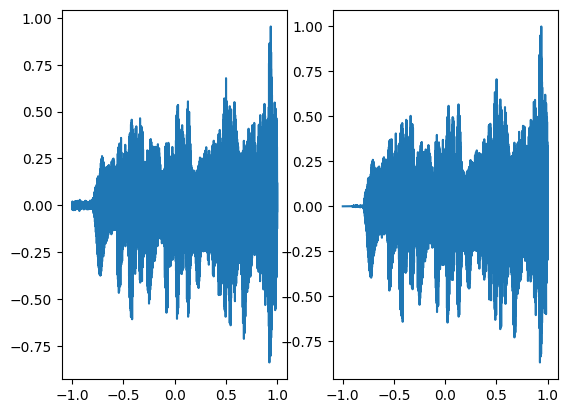

MSE Mean: 0.0004399790
MSE Standard Dev.: 0.0009672651


In [8]:
total_steps = 500
steps_til_summary = 150



audio_siren = Siren(in_features=1, out_features=1, hidden_features=256,
                hidden_layers=3, first_omega_0=3000, outermost_linear=True)
audio_siren.cuda()
optim = torch.optim.Adam(lr=1e-4, params=audio_siren.parameters())

model_input, ground_truth = next(iter(dataloader))
model_input, ground_truth = model_input.cuda(), ground_truth.cuda()

for step in range(total_steps):
    model_output, coords = audio_siren(model_input)
    loss = F.mse_loss(model_output, ground_truth)

    if not step % steps_til_summary:
        print("Step %d, Total loss %0.6f" % (step, loss))
        fig, axes = plt.subplots(1,2)
        axes[0].plot(coords.squeeze().detach().cpu().numpy(),model_output.squeeze().detach().cpu().numpy())
        axes[1].plot(coords.squeeze().detach().cpu().numpy(),ground_truth.squeeze().detach().cpu().numpy())
        plt.show()

    optim.zero_grad()
    loss.backward()
    optim.step()


final_model_output, coords = audio_siren(model_input)
mse = (ground_truth - final_model_output) ** 2
mse_mean = mse.mean()
mse_std = mse.std()

# Print the results with four decimal places
print("MSE Mean: {:.10f}".format(mse_mean.item()))
print("MSE Standard Dev.: {:.10f}".format(mse_std.item()))


# Bach Audio (Secret Representation)



Step 0, Total loss 0.024778


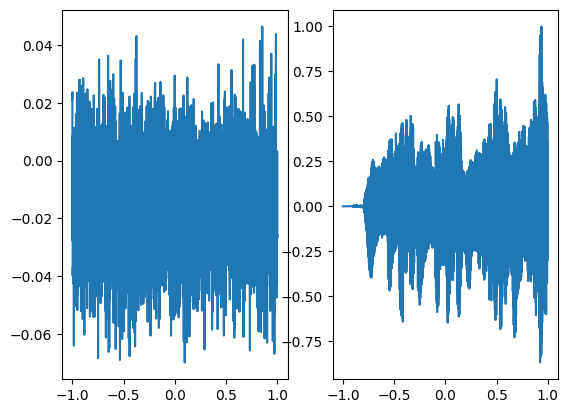

Step 150, Total loss 0.001978


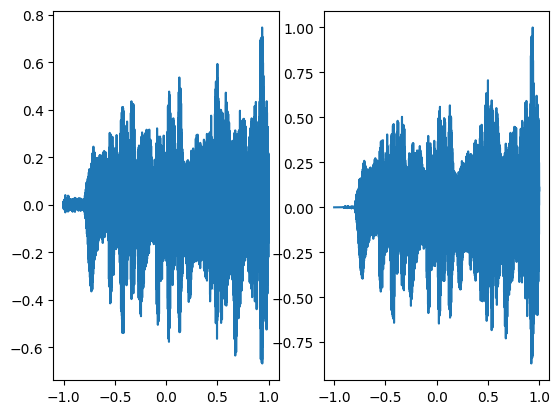

Step 300, Total loss 0.000841


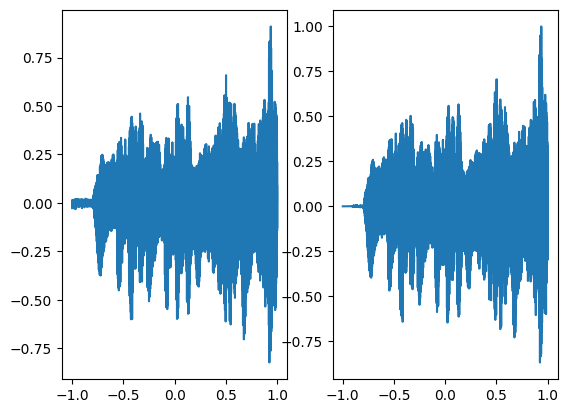

Step 450, Total loss 0.000558


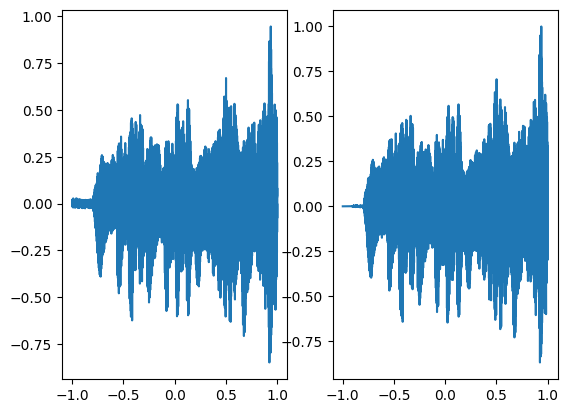

MSE Mean: 0.0005371401
MSE Standard Dev.: 0.0012861257


In [9]:
total_steps = 500
steps_til_summary = 150


    

audio_siren = Siren(in_features=1, out_features=1, hidden_features=256,
                hidden_layers=3, first_omega_0=3000, outermost_linear=True)
audio_siren.cuda()

from utils_pus import generate_sparse_mask, remove_adapter, insert_adapter
sparse_mask = generate_sparse_mask(audio_siren.cpu(), sparse_ratio=0.5)
remove_adapter(audio_siren.cuda(), sparse_mask)
optim = torch.optim.Adam(lr=1e-4, params=audio_siren.parameters())

model_input, ground_truth = next(iter(dataloader))
model_input, ground_truth = model_input.cuda(), ground_truth.cuda()

for step in range(total_steps):
    remove_adapter(audio_siren.cuda(), sparse_mask)
    model_output, coords = audio_siren(model_input)
    loss = F.mse_loss(model_output, ground_truth)

    if not step % steps_til_summary:
        print("Step %d, Total loss %0.6f" % (step, loss))
        fig, axes = plt.subplots(1,2)
        axes[0].plot(coords.squeeze().detach().cpu().numpy(),model_output.squeeze().detach().cpu().numpy())
        axes[1].plot(coords.squeeze().detach().cpu().numpy(),ground_truth.squeeze().detach().cpu().numpy())
        plt.show()
        
    optim.zero_grad()
    loss.backward()
    optim.step()
        

remove_adapter(audio_siren.cuda(), sparse_mask)
final_model_output, coords = audio_siren(model_input)

mse = (ground_truth - final_model_output) ** 2
mse_mean = mse.mean()
mse_std = mse.std()


# Print the results with four decimal places
print("MSE Mean: {:.10f}".format(mse_mean.item()))
print("MSE Standard Dev.: {:.10f}".format(mse_std.item()))



In [10]:
final_model_output, coords = audio_siren(model_input)
Audio(final_model_output.cpu().detach().squeeze().numpy(),rate=rate)

# Cover Representation (Counting Audio) ---- Bach in Counting



In [11]:
cover_bach_audio = AudioFile('./data/gt_counting.wav')

cover_dataloader = DataLoader(cover_bach_audio, shuffle=True, batch_size=1, pin_memory=True, num_workers=0)
model_input, ground_truth = next(iter(cover_dataloader))
##### GT Counting
Audio(ground_truth.squeeze().numpy(),rate=rate)

Step 0, Total loss 0.023381


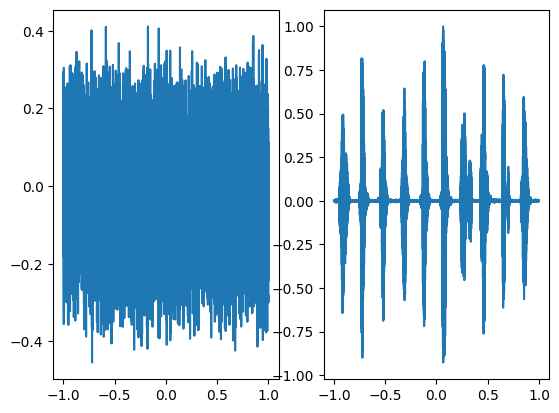

Step 150, Total loss 0.001384


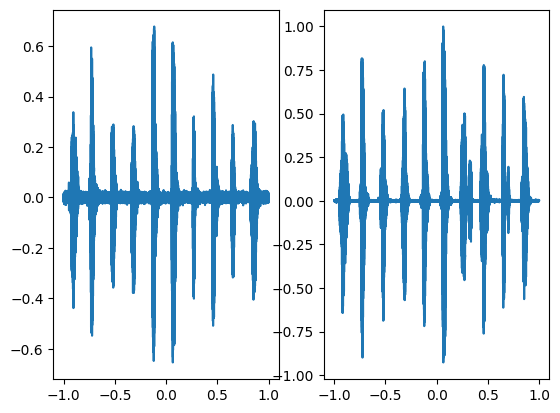

Step 300, Total loss 0.001055


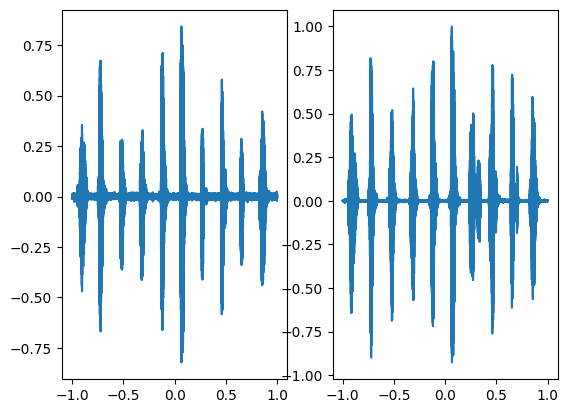

Step 450, Total loss 0.000951


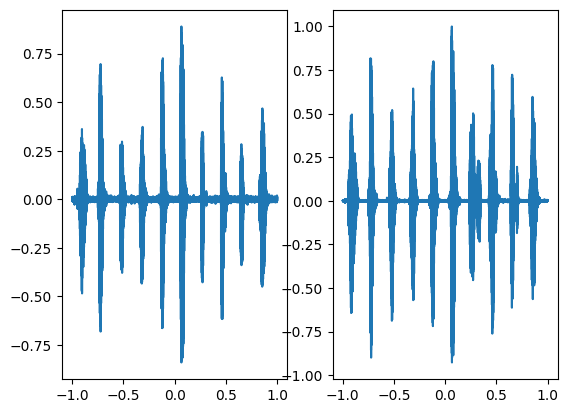

MSE Mean: 0.0009203606
MSE Standard Dev.: 0.0059752017


In [12]:
total_steps = 500
steps_til_summary = 150




model_input, ground_truth = model_input.cuda(), ground_truth.cuda()


cover_audio_siren = Siren(in_features=1, out_features=1, hidden_features=256,
                hidden_layers=3, first_omega_0=3000, outermost_linear=True)
cover_audio_siren.cuda()

insert_adapter(cover_audio_siren, sparse_mask, audio_siren)
optim = torch.optim.Adam(lr=1e-4, params=cover_audio_siren.parameters())



for step in range(total_steps):
    insert_adapter(cover_audio_siren, sparse_mask, audio_siren)
    model_output, coords = cover_audio_siren(model_input)
    loss = F.mse_loss(model_output, ground_truth)

    if not step % steps_til_summary:
        print("Step %d, Total loss %0.6f" % (step, loss))
        fig, axes = plt.subplots(1,2)
        axes[0].plot(coords.squeeze().detach().cpu().numpy(),model_output.squeeze().detach().cpu().numpy())
        axes[1].plot(coords.squeeze().detach().cpu().numpy(),ground_truth.squeeze().detach().cpu().numpy())
        plt.show()


    optim.zero_grad()
    loss.backward()
    optim.step()

insert_adapter(cover_audio_siren, sparse_mask, audio_siren)
final_model_output, coords = cover_audio_siren(model_input)
mse = (ground_truth - final_model_output) ** 2

mse_mean = mse.mean()
mse_std = mse.std()


# Print the results with four decimal places
print("MSE Mean: {:.10f}".format(mse_mean.item()))
print("MSE Standard Dev.: {:.10f}".format(mse_std.item()))


In [13]:
## Counting (Cover Representation)
final_model_output, coords = cover_audio_siren(model_input)
Audio(final_model_output.cpu().detach().squeeze().numpy(),rate=rate)

In [14]:
## Extracting Bach audio (Secret) from Counting (Cover)
remove_adapter(cover_audio_siren.cuda(), sparse_mask)
model_input, ground_truth = next(iter(dataloader))
final_model_output, coords = cover_audio_siren(model_input.cuda())
Audio(final_model_output.cpu().detach().squeeze().numpy(),rate=44100)
